In [1]:
#================================================
# DATA
#================================================

import duckdb, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# creating the conection to the duckdb database file:
con = duckdb.connect("movielens100K.duckdb")

In [2]:
IMDB_DIR = Path("..") / "data" / "Imdb"
IMDB_DIR

WindowsPath('../data/Imdb')

### 1.0 Temporary Views to query Imdb File composition
#### 1.1 Creation of view with File "name.basics.tsv"

In [3]:
# Creating the view for the name.basics file
con.sql(f"""
CREATE OR REPLACE VIEW imdb_name_basics AS
SELECT *
FROM read_csv_auto(
    '{IMDB_DIR / "name.basics.tsv"}',
    delim='\t',
    header=TRUE,
    nullstr='\\N'
)
""")

In [4]:
# Reviewing the structure of the imdb_name_basics table
con.sql("DESCRIBE imdb_name_basics").df()


,column_name,column_type,null,key,default,extra
0,nconst,VARCHAR,YES,None,None,None
1,primaryName,VARCHAR,YES,None,None,None
2,birthYear,BIGINT,YES,None,None,None
3,deathYear,BIGINT,YES,None,None,None
4,primaryProfession,VARCHAR,YES,None,None,None
5,knownForTitles,VARCHAR,YES,None,None,None


In [5]:
# Reviewing some data from the imdb_name_basics table
con.sql("SELECT * FROM imdb_name_basics LIMIT 3").df()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0027125,tt0025164"
1,nm0000002,Lauren Bacall,1924,2014,"actress,miscellaneous,soundtrack","tt0037382,tt0075213,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934,<NA>,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"


In [6]:
# count of the number of distinct professions in the table and diferent profissions in the dataset
professions_df=con.sql("""
        WITH all_professions AS (
        SELECT UNNEST(str_split(primaryProfession, ',')) AS profession 
        FROM imdb_name_basics
    ),
    count_professions AS (
        SELECT COUNT(DISTINCT profession) AS distinct_professions
        FROM all_professions
    ),
    professions_stats AS (
        SELECT profession,
        COUNT(*) AS total
    FROM all_professions
    GROUP BY profession
    ),
    union_table AS (
    
    SELECT
        'TOTAL_DISTINCT_PROFESSIONS' AS profession,
        (SELECT distinct_professions FROM count_professions) AS total
    UNION ALL
    SELECT
        profession,
        total
    FROM professions_stats
    )
    SELECT *
    FROM union_table
    ORDER BY
        CASE WHEN profession = 'TOTAL_DISTINCT_PROFESSIONS' THEN 0 ELSE 1 END,
        total DESC
    --LIMIT 15
 """).df()

professions_df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,profession,total
0,TOTAL_DISTINCT_PROFESSIONS,46
1,actor,3416592
2,actress,2064541
3,producer,1310782
4,miscellaneous,1180042
5,writer,982986
6,camera_department,871746
7,director,804070
8,production_department,586470
9,art_department,463038


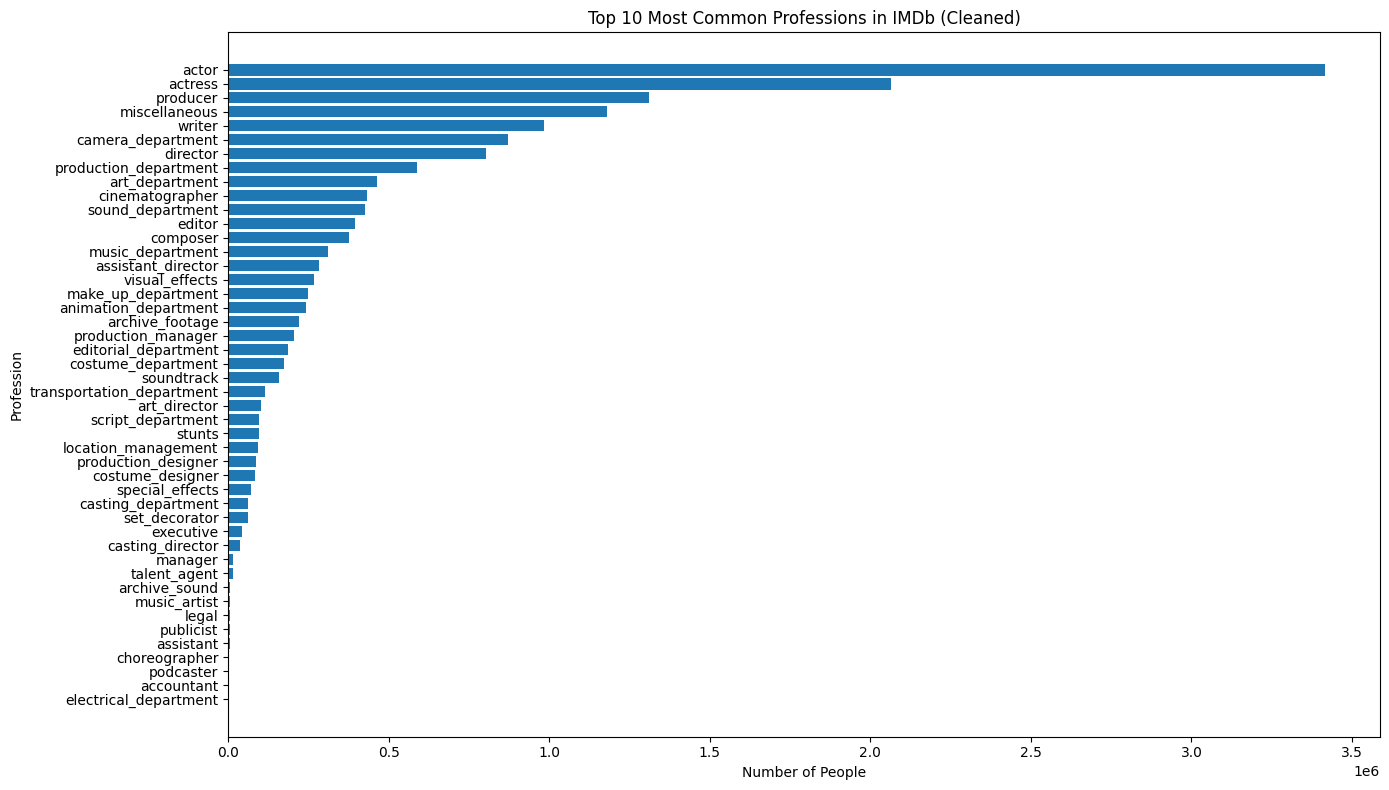

In [7]:
# Making a bar graph with query results

professions_df = professions_df.iloc[1:]

plt.figure(figsize=(14, 8))
plt.barh(professions_df["profession"], professions_df["total"])
plt.xlabel("Number of People")
plt.ylabel("Profession")
plt.title("Top 10 Most Common Professions in IMDb (Cleaned)")
plt.gca().invert_yaxis()  # Maior valor no topo
plt.tight_layout()
plt.show()

#### 1.2 Creation of view with File "title.basics.tsv"

In [8]:
# Creating the view for the title.basics file
con.sql(f"""
CREATE OR REPLACE VIEW imdb_title_basics AS
SELECT *
FROM read_csv_auto(
    '{IMDB_DIR / "title.basics.tsv"}',
    delim='\t',
    header=TRUE,
    nullstr='\\N'
)
""")

In [9]:
# Reviewing the structure of the imdb_title_basics table
con.sql("describe imdb_title_basics").df()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,titleType,VARCHAR,YES,None,None,None
2,primaryTitle,VARCHAR,YES,None,None,None
3,originalTitle,VARCHAR,YES,None,None,None
4,isAdult,BIGINT,YES,None,None,None
5,startYear,BIGINT,YES,None,None,None
6,endYear,VARCHAR,YES,None,None,None
7,runtimeMinutes,BIGINT,YES,None,None,None
8,genres,VARCHAR,YES,None,None,None


In [10]:
# Reviewing some data from the imdb_title_basics table
con.sql("SELECT * FROM imdb_title_basics LIMIT 3").df()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,None,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,None,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,None,5,"Animation,Comedy,Romance"


In [11]:
# How many films does this Db has
con.sql("""
SELECT COUNT(DISTINCT tconst) AS total_titles
FROM imdb_title_basics
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,total_titles
0,12063211


#### 1.3 Creation of view with File "title.crew.tsv"

In [12]:
con.sql(f"""
CREATE OR REPLACE VIEW imdb_title_crew AS
SELECT *
FROM read_csv_auto(
    '{IMDB_DIR / "title.crew.tsv"}',
    delim='\t',
    header=TRUE,
    nullstr='\\N'
)
""")


In [13]:
# Reviewing the structure of the imdb_title_crew table
con.sql("DESCRIBE imdb_title_crew").df()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,directors,VARCHAR,YES,None,None,None
2,writers,VARCHAR,YES,None,None,None


In [14]:
# Reviewing some data from the imdb_title_crew table
con.sql("SELECT * FROM imdb_title_crew LIMIT 3").df()

,tconst,directors,writers
0,tt0000001,nm0005690,None
1,tt0000002,nm0721526,None
2,tt0000003,nm0721526,nm0721526


In [15]:
# How many diferent directors and writers this DB has
con.sql("""
SELECT COUNT(DISTINCT tconst) AS titles_count,COUNT(DISTINCT directors) AS directors_count, COUNT(DISTINCT writers) AS writers_count
FROM imdb_title_crew
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,titles_count,directors_count,writers_count
0,12064777,984266,1463383


Database with important information: Director and writer name by movie.

#### 1.4 Creation of view with File "title.principals.tsv"
##### 1.4.1 General exploration

In [16]:
# Creating the view for the principals file
con.sql(f"""
CREATE OR REPLACE VIEW imdb_principals AS
SELECT *
FROM read_csv_auto(
    '{IMDB_DIR / "title.principals.tsv"}',
    delim='\t',
    header=TRUE,
    nullstr='\\N'
)
""")


In [17]:
# Reviewing the structure of the imdb_principals table
con.sql("DESCRIBE imdb_principals").df()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,ordering,BIGINT,YES,None,None,None
2,nconst,VARCHAR,YES,None,None,None
3,category,VARCHAR,YES,None,None,None
4,job,VARCHAR,YES,None,None,None
5,characters,VARCHAR,YES,None,None,None


In [18]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM imdb_principals LIMIT 10").df()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,None,"[""Self""]"
1,tt0000001,2,nm0005690,director,None,None
2,tt0000001,3,nm0005690,producer,producer,None
3,tt0000001,4,nm0374658,cinematographer,director of photography,None
4,tt0000002,1,nm0721526,director,None,None
5,tt0000002,2,nm1335271,composer,None,None
6,tt0000003,1,nm0721526,director,None,None
7,tt0000003,2,nm0721526,writer,None,None
8,tt0000003,3,nm1770680,producer,producer,None
9,tt0000003,4,nm0721526,producer,producer,None


In [19]:
# Count of the different categories and number of occurrences of each one
con.sql("""
    SELECT
        p.category,
        COUNT(*) AS total
    FROM imdb_principals AS p
    JOIN imdb_map_ids AS map
        ON p.tconst = map.tconst  
    JOIN movies AS m
        ON m.movieId = map.movieId
    GROUP BY p.category
    ORDER BY total DESC;
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,category,total
0,actor,63983
1,actress,30713
2,writer,20689
3,producer,19107
4,editor,12150
5,casting_director,10683
6,director,10389
7,composer,10190
8,cinematographer,9936
9,production_designer,8019


In [20]:
# Count of the different jobs and number of occurrences of each one
con.sql("""
    SELECT
        p.job,
        COUNT(*) AS total
    FROM imdb_principals AS p
    JOIN imdb_map_ids AS map
        ON p.tconst = map.tconst        -- Link IMDb tconst -> MovieLens movieId
    JOIN movies AS m
        ON m.movieId = map.movieId      -- Ensure the movie exists in MovieLens
    GROUP BY p.job
    ORDER BY total DESC
    LIMIT 30;
""").df()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,job,total
0,None,143293
1,producer,18898
2,director of photography,5706
3,written by,5396
4,screenplay,4549
5,composer,2554
6,casting_director,2331
7,editor,2140
8,director,1840
9,story,1666


##### 1.4.2 category=producer in "imdb_principals" view 

In [21]:
# Count wich and how many times jobs appears for category = 'producer'
df_job_top = con.execute("""
    SELECT
        p.job,
        COUNT(*) AS job_count
    FROM imdb_principals AS p
    JOIN imdb_map_ids AS map
        ON p.tconst = map.tconst        -- link IMDb title to MovieLens movieId
    JOIN movies AS m
        ON m.movieId = map.movieId      -- ensure the movie exists in MovieLens
    WHERE p.category = 'producer'
      AND p.job IS NOT NULL             -- ignore NULL jobs (optional)
    GROUP BY p.job
    ORDER BY job_count DESC
    LIMIT 20;
""").df()

df_job_top



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,job,job_count
0,producer,18898
1,executive producer,171
2,line producer,22
3,associate producer,5
4,creative producer,2
5,executive producer: Canada,1
6,chief executive producer,1
7,executive producer: Europe,1
8,chief producer,1
9,planner,1


##### 1.4.3 category=writer in "imdb_principals" view

In [22]:
# Count wich and how many times jobs appears for category = 'writer'
df_job_top = con.execute("""
    SELECT
        p.job,
        COUNT(*) AS job_count
    FROM imdb_principals AS p
    JOIN imdb_map_ids AS map
        ON p.tconst = map.tconst        -- link IMDb title to MovieLens movieId
    JOIN movies AS m
        ON m.movieId = map.movieId      -- ensure the movie exists in MovieLens
    WHERE p.category = 'writer'
      AND p.job IS NOT NULL             -- ignore NULL jobs (optional)
    GROUP BY p.job
    ORDER BY job_count DESC
    LIMIT 25;
""").df()

df_job_top


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,job,job_count
0,written by,5396
1,screenplay,4549
2,story,1666
3,screenplay by,1207
4,novel,623
5,writer,554
6,story by,376
7,characters,342
8,screen play,257
9,book,200


##### 1.4.4 category=Director in "imdb_principals" view

In [23]:
# Count wich and how many times jobs appears for category = 'director'
df_job_top = con.execute("""
    SELECT
        p.job,
        COUNT(*) AS job_count
    FROM imdb_principals AS p
    JOIN imdb_map_ids AS map
        ON p.tconst = map.tconst        -- link IMDb title to MovieLens movieId
    JOIN movies AS m
        ON m.movieId = map.movieId      -- ensure movie exists in MovieLens dataset
    WHERE p.category = 'director'
      AND p.job IS NOT NULL             -- ignore NULL jobs (optional)
    GROUP BY p.job
    ORDER BY job_count DESC
    LIMIT 20;
""").df()

df_job_top

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,job,job_count
0,director,1840
1,sequence director,31
2,supervising director,20
3,chief director,10
4,series director,6
5,segment director,3
6,animation director,2
7,general director,2
8,photoplay director,1
9,documentary director,1


#### 1.5 Creation of view with File "title.ratings.tsv"

In [24]:
# Creating the view for the title.episode file
con.sql(f"""
CREATE OR REPLACE VIEW imdb_ratings AS
SELECT *
FROM read_csv_auto('{IMDB_DIR / "title.ratings.tsv"}', delim='\t', header=TRUE)
""")

In [25]:
# Reviewing the structure of the imdb_ratings table
con.sql("DESCRIBE imdb_ratings").df()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,averageRating,DOUBLE,YES,None,None,None
2,numVotes,BIGINT,YES,None,None,None


In [26]:
# Reviewing some data from the imdb_ratings table
con.sql("SELECT * FROM imdb_ratings LIMIT 5").df()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2184
1,tt0000002,5.5,305
2,tt0000003,6.4,2267
3,tt0000004,5.2,196
4,tt0000005,6.2,3008


In [27]:
# Some statistics about the ratings and votes
con.sql("""
SELECT
    COUNT(*)                        AS total_filmes,
    MIN(averageRating)              AS min_rating,
    MAX(averageRating)              AS max_rating,
    AVG(averageRating)              AS media_rating,
    MIN(numVotes)                   AS min_votes,
    MAX(numVotes)                   AS max_votes,
    AVG(numVotes)                   AS media_votes
FROM imdb_ratings
""").df()

,total_filmes,min_rating,max_rating,media_rating,min_votes,max_votes,media_votes
0,1624197,1.0,10.0,6.932189,5,3120155,1025.548522


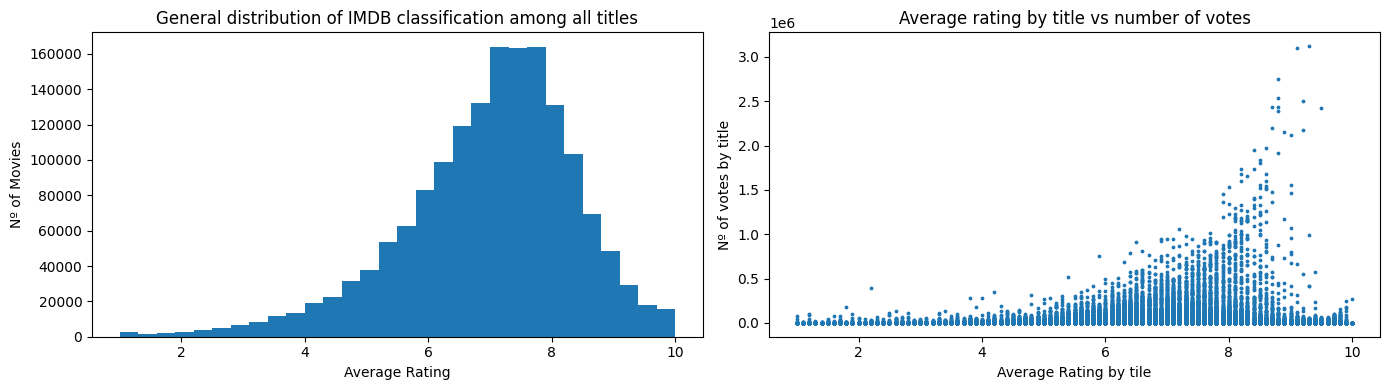

In [28]:
# Visualizing the distribution of ratings and votes
df_ratings = con.sql("SELECT averageRating FROM imdb_ratings").df()
df_votes   = con.sql("SELECT numVotes, averageRating FROM imdb_ratings WHERE numVotes < 50000000000").df()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14,4))

# --- gráfic 1: hist rating
axes[0].hist(df_ratings["averageRating"], bins=30)
axes[0].set_title("General distribution of IMDB classification among all titles")
axes[0].set_xlabel("Average Rating")
axes[0].set_ylabel("Nº of Movies")

# --- gráfico 2: scatter
axes[1].scatter(df_votes["averageRating"], df_votes["numVotes"], s=3)
axes[1].set_title("Average rating by title vs number of votes")
axes[1].set_xlabel("Average Rating by tile")
axes[1].set_ylabel("Nº of votes by title")

plt.tight_layout()
plt.show()


#### 1.6 Summary of Imdb info

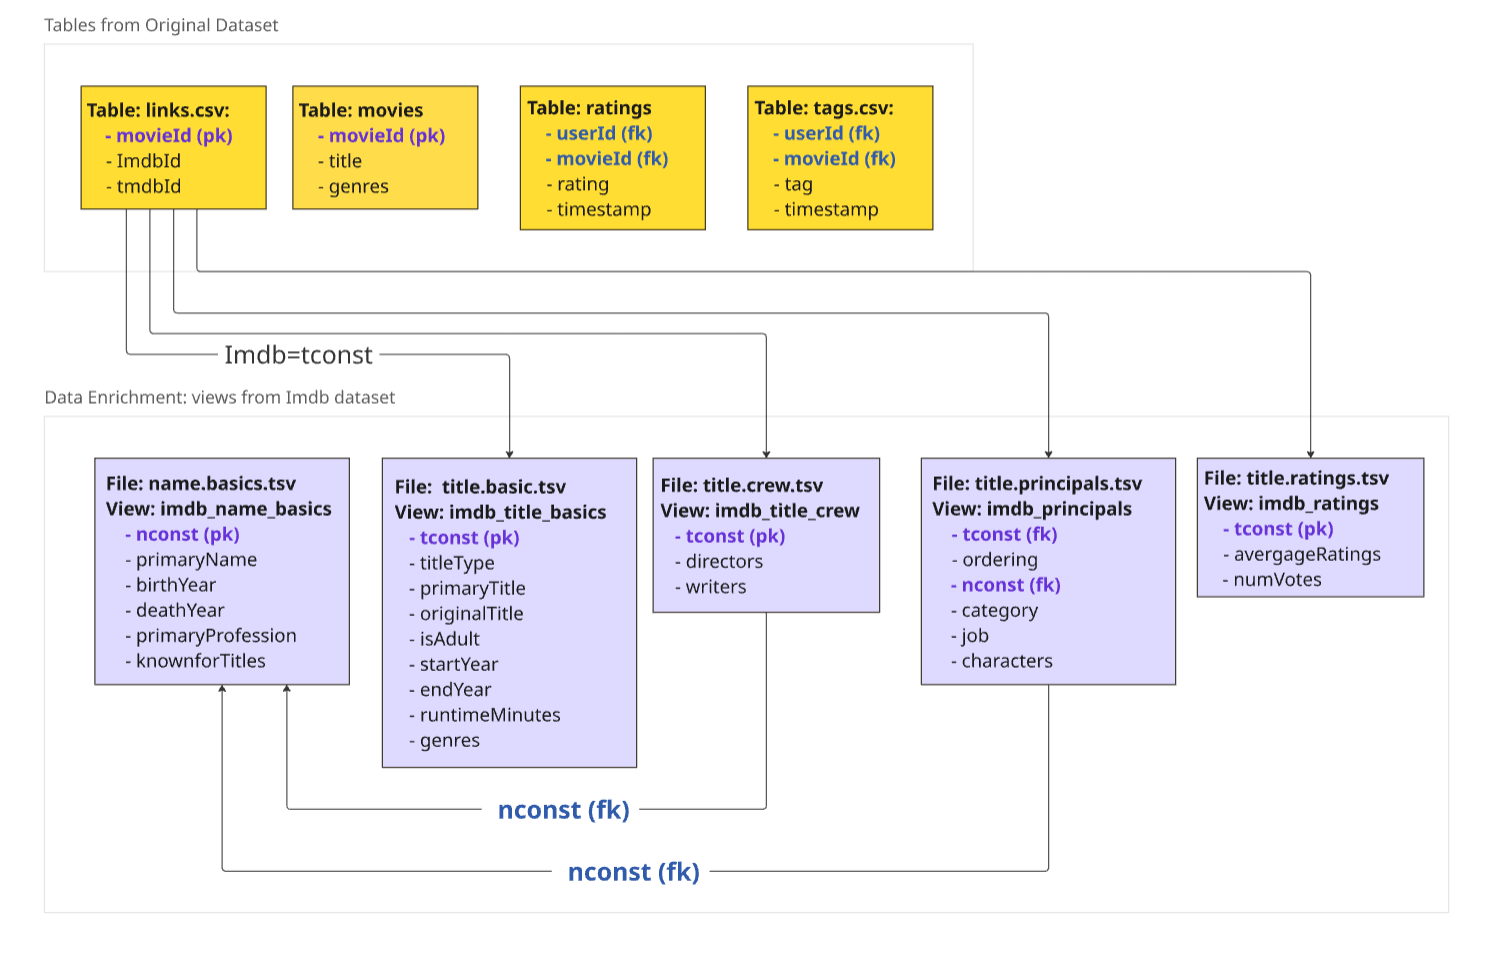

In [29]:
# List of all tables in the database
con.sql("""
SELECT table_name, table_type
FROM information_schema.tables
""").df()

,table_name,table_type
0,imdb_principals_writers,BASE TABLE
1,links,BASE TABLE
2,movielens_actors,BASE TABLE
3,movielens_directors,BASE TABLE
4,movielens_main_producers,BASE TABLE
5,movielens_ratings_imdb,BASE TABLE
6,movielens_writers,BASE TABLE
7,movies,BASE TABLE
8,ratings,BASE TABLE
9,tags,BASE TABLE


### 2.0 Data enrichment with Imdb dataset
#### 2.1 Creation of table view with movies ID (imdb and movielens)

In [30]:
# Df Creation with link between movielens and Imdb links
con.sql("""
CREATE OR REPLACE VIEW imdb_map_ids AS
SELECT
    movieId,
    'tt' || LPAD(imdbId, 7, '0') AS tconst
FROM links
WHERE imdbId IS NOT NULL;
""")

In [31]:
# Reviewing some data from the imdbmaps_ids table
con.sql("SELECT * FROM imdb_map_ids LIMIT 10").df()

,movieId,tconst
0,1,tt0114709
1,2,tt0113497
2,3,tt0113228
3,4,tt0114885
4,5,tt0113041
5,6,tt0113277
6,7,tt0114319
7,8,tt0112302
8,9,tt0114576
9,10,tt0113189


In [32]:
# How many MovieLens movies have link to imdbId?
con.sql("""
SELECT COUNT(*) AS movielens_movies_count,
       COUNT(imdbId) AS movies_with_link,
       COUNT(*) - COUNT(imdbId) AS movies_without_link
FROM links
""").df()


,movielens_movies_count,movies_with_link,movies_without_link
0,9742,9742,0


#### 2.2 Creation of table with movielens movie Directors

In [33]:
# Creation of table movielens_directors
con.sql("""
CREATE OR REPLACE TABLE movielens_directors AS
SELECT
    m.movieId,
    m.title,
    nb.primaryName AS director_name
FROM movies AS m
JOIN imdb_map_ids AS map ON map.movieId = m.movieId
JOIN imdb_title_crew AS c ON c.tconst = map.tconst
-- explode comma-separated directors into rows
CROSS JOIN UNNEST(str_split(c.directors, ',')) AS d(director_nconst_raw)
LEFT JOIN imdb_name_basics AS nb
    ON nb.nconst = TRIM(d.director_nconst_raw)
WHERE c.directors IS NOT NULL
  AND c.directors <> '';
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [34]:
# Query: count distinct and non-distinct movieId values
df_counts = con.execute("""
    SELECT
        COUNT(movieId) AS total_rows,              -- non-distinct
        COUNT(DISTINCT movieId) AS distinct_rows   -- distinct
    FROM movielens_directors;
""").df()

print(df_counts)

   total_rows  distinct_rows
0       11028           9717


In [35]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_directors LIMIT 5").df()

,movieId,title,director_name
0,49265,Shooting Dogs (a.k.a. Beyond the Gates) (2005),Michael Caton-Jones
1,37382,Domino (2005),Tony Scott
2,59016,Street Kings (2008),David Ayer
3,55444,Control (2007),Anton Corbijn
4,48161,Gridiron Gang (2006),Phil Joanou


In [36]:
# Query to determine how many films from our original dataset find a match for their director here, and how many do not.
con.sql("""
WITH t AS (
    SELECT COUNT(*) AS total_movies FROM movies
),
d AS (
    SELECT COUNT(DISTINCT movieId) AS movies_with_director
    FROM movielens_directors
)
SELECT
    t.total_movies,
    d.movies_with_director,
    t.total_movies - d.movies_with_director AS movies_without_director
FROM t, d;
""").df()

,total_movies,movies_with_director,movies_without_director
0,9742,9717,25


In [37]:
top_directors = con.sql("""
SELECT
    director_name,
    COUNT(*) AS total_movies
FROM movielens_directors
WHERE director_name IS NOT NULL
GROUP BY director_name
ORDER BY total_movies DESC
LIMIT 10;
""").df()

top_directors


,director_name,total_movies
0,Woody Allen,48
1,Alfred Hitchcock,37
2,Steven Spielberg,33
3,Clint Eastwood,32
4,Martin Scorsese,30
5,Ridley Scott,24
6,Ron Howard,24
7,Steven Soderbergh,23
8,Spike Lee,22
9,Barry Levinson,21


In [38]:
# Compute mean, median and mode of number of directors per film
con.sql("""
WITH director_counts AS (
    SELECT
        movieId,
        COUNT(*) AS num_directors
    FROM movielens_directors
    GROUP BY movieId
),
mode_calc AS (
    SELECT
        num_directors,
        COUNT(*) AS freq,
        ROW_NUMBER() OVER (ORDER BY COUNT(*) DESC) AS rn
    FROM director_counts
    GROUP BY num_directors
)
SELECT
    AVG(num_directors) AS mean_directors,
    MEDIAN(num_directors) AS median_directors,
    (SELECT num_directors FROM mode_calc WHERE rn = 1) AS mode_directors
FROM director_counts
        """).df()

,mean_directors,median_directors,mode_directors
0,1.134918,1.0,1


#### 2.3 Creation of table with movielens movie Writers

In [39]:
# Creation of table movielens_writers
con.sql("""
CREATE OR REPLACE TABLE movielens_writers AS
SELECT
    m.movieId,
    m.title,
    nb.primaryName AS writer_name
FROM movies AS m
JOIN imdb_map_ids AS map
    ON map.movieId = m.movieId
JOIN imdb_title_crew AS c
    ON c.tconst = map.tconst
CROSS JOIN UNNEST(str_split(c.writers, ',')) AS d(writer_nconst_raw)
LEFT JOIN imdb_name_basics AS nb
    ON nb.nconst = TRIM(d.writer_nconst_raw)
WHERE c.writers IS NOT NULL
  AND c.writers <> ''
  AND c.writers <> '\\N';
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [40]:
# Query: count distinct and non-distinct movieId values
df_counts = con.execute("""
    SELECT
        COUNT(movieId) AS total_rows,              -- non-distinct
        COUNT(DISTINCT movieId) AS distinct_rows   -- distinct
    FROM movielens_writers;
""").df()

print(df_counts)

   total_rows  distinct_rows
0       24079           9556


In [41]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_writers LIMIT 5").df()

,movieId,title,writer_name
0,180777,Die Frauen von Ravensbrück (2005),Loretta Walz
1,54185,Manufactured Landscapes (2006),Lucas Lackner
2,65682,Underworld: Rise of the Lycans (2009),Kevin Grevioux
3,97225,Hotel Transylvania (2012),Kevin Hageman
4,55269,"Darjeeling Limited, The (2007)",Jason Schwartzman


In [42]:
# Query to determine writers with more movies in the dataset
top_writers = con.sql("""
SELECT
    writer_name,
    COUNT(*) AS total_movies
FROM movielens_writers
WHERE writer_name IS NOT NULL
GROUP BY writer_name
ORDER BY total_movies DESC
LIMIT 10;
""").df()

top_writers


,writer_name,total_movies
0,Woody Allen,51
1,Stephen King,47
2,Luc Besson,37
3,Jack Kirby,37
4,Stan Lee,32
5,William Shakespeare,32
6,John Hughes,32
7,Ben Hecht,32
8,Bob Kane,29
9,Ian Fleming,26


In [43]:
# Coverage: how many ML movies have at least one writer mapped vs not
con.sql("""
WITH t AS (
    SELECT COUNT(*) AS total_movies FROM movies
),
w AS (
    SELECT COUNT(DISTINCT movieId) AS movies_with_writer
    FROM movielens_writers
)
SELECT
    t.total_movies,
    w.movies_with_writer,
    t.total_movies - w.movies_with_writer AS movies_without_writer
FROM t, w;
""").df()

,total_movies,movies_with_writer,movies_without_writer
0,9742,9556,186


In [44]:
# Movies with more than one writer (list names if you want)
con.sql("""
SELECT
    movieId,
    title,
    COUNT(DISTINCT writer_name) AS num_writers
FROM movielens_writers
GROUP BY movieId, title
HAVING COUNT(DISTINCT writer_name) > 1
ORDER BY num_writers DESC, title;
""").df()

,movieId,title,num_writers
0,1907,Mulan (1998),32
1,364,"Lion King, The (1994)",29
2,50912,"Paris, I Love You (Paris, je t'aime) (2006)",29
3,6889,Brother Bear (2003),27
4,132888,Comedy Central Roast of James Franco (2013),27
...,...,...,...
6668,2698,Zone 39 (1997),2
6669,60885,"Zone, The (La Zona) (2007)",2
6670,156553,Zoom (2015),2
6671,5899,Zulu (1964),2


This table show 32 writers of the movie "mulan", what seems to that does not make sense: after visiting IMDB page is undertanded that there are several diferent writers but only one general wrting. 

link: https://www.imdb.com/title/tt0120762/fullcredits/?ref_=tt_ov_sm_2#amzn1.imdb.concept.name_credit_category.c84ecaff-add5-4f2e-81db-102a41881fe3
 

In [45]:
# Create a table with writers based on imdb_principals (category = 'writer')
con.sql("""
    CREATE OR REPLACE TABLE imdb_principals_writers AS
    SELECT
        m.movieId,
        m.title,
        nb.primaryName AS writer_name,
        p.job
    FROM movies AS m
    JOIN imdb_map_ids AS map
        ON map.movieId = m.movieId          -- Link MovieLens -> IMDb (tconst)
    JOIN imdb_principals AS p
        ON p.tconst = map.tconst            -- Use IMDb title id
    JOIN imdb_name_basics AS nb
        ON nb.nconst = p.nconst             -- Get writer's name
    WHERE p.category = 'writer';
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [46]:
# Check row counts for both tables
con.sql("SELECT 'movielens_writers' AS table_name, COUNT(*) AS row_count FROM movielens_writers UNION ALL SELECT 'imdb_principals_writers', COUNT(*) FROM imdb_principals_writers").df()


,table_name,row_count
0,movielens_writers,24079
1,imdb_principals_writers,20689


In [47]:
# Writers present in imdb_principals_writers but missing in movielens_writers
df_only_principals = con.execute("""
    SELECT 
        ipw.movieId,
        ipw.title,
        ipw.writer_name,
        ipw.job
    FROM imdb_principals_writers AS ipw
    LEFT JOIN movielens_writers AS mw
        ON ipw.movieId = mw.movieId
       AND ipw.writer_name = mw.writer_name
    WHERE mw.writer_name IS NULL
""").df()

df_only_principals


,movieId,title,writer_name,job


In [48]:
# Writers present in movielens_writers but missing in imdb_principals_writers
df_only_movielens = con.execute("""
    SELECT 
        mw.movieId,
        mw.title,
        mw.writer_name
    FROM movielens_writers AS mw
    LEFT JOIN imdb_principals_writers AS ipw
        ON mw.movieId = ipw.movieId
       AND mw.writer_name = ipw.writer_name
    WHERE ipw.writer_name IS NULL
""").df()

df_only_movielens


,movieId,title,writer_name
0,65682,Underworld: Rise of the Lycans (2009),Kevin Grevioux
1,97225,Hotel Transylvania (2012),Kevin Hageman
2,66798,"Pink Panther 2, The (2009)",Blake Edwards
3,71264,Cloudy with a Chance of Meatballs (2009),Rob Greenberg
4,102720,Epic (2013),Chris Wedge
...,...,...,...
3384,2033,"Black Cauldron, The (1985)",Richard Rich
3385,709,Oliver & Company (1988),Chris Bailey
3386,709,Oliver & Company (1988),Jim Mitchell
3387,709,Oliver & Company (1988),Joe Ranft


In [49]:
# Compare number of writers per movie between both tables
df_writer_counts = con.execute("""
    WITH ml AS (
        SELECT movieId, COUNT(*) AS ml_writer_count
        FROM movielens_writers
        GROUP BY movieId
    ),
    ip AS (
        SELECT movieId, COUNT(*) AS ip_writer_count
        FROM imdb_principals_writers
        GROUP BY movieId
    )
    SELECT
        COALESCE(ml.movieId, ip.movieId) AS movieId,
        ml.ml_writer_count,
        ip.ip_writer_count
    FROM ml
    FULL OUTER JOIN ip
        USING (movieId)
    ORDER BY movieId
""").df()

df_writer_counts


,movieId,ml_writer_count,ip_writer_count
0,1,7,4
1,2,4,4
2,3,1,1
3,4,2,2
4,5,4,4
...,...,...,...
9551,193581,2,2
9552,193583,2,2
9553,193585,2,2
9554,193587,3,3


In [50]:

# Set the movieId you want to inspect
movie_id = 1907  # <--- CHANGE THIS

# Query to compare writers side-by-side for a given movieId
df_compare = con.execute(f"""
    SELECT
        COALESCE(mw.movieId, ipw.movieId) AS movieId,
        COALESCE(mw.title, ipw.title) AS title,     -- Get movie title
        mw.writer_name AS movielens_writer,
        ipw.writer_name AS imdb_writer,
        ipw.job AS imdb_job
    FROM movielens_writers AS mw
    FULL OUTER JOIN imdb_principals_writers AS ipw
        ON mw.movieId = ipw.movieId
       AND mw.writer_name = ipw.writer_name
    WHERE COALESCE(mw.movieId, ipw.movieId) = {movie_id}
    ORDER BY movielens_writer, imdb_writer;
""").df()

# Display the result
df_compare



,movieId,title,movielens_writer,imdb_writer,imdb_job
0,1907,Mulan (1998),Alan Ormsby,None,None
1,1907,Mulan (1998),Barry Johnson,None,None
2,1907,Mulan (1998),Burny Mattinson,None,None
3,1907,Mulan (1998),Chris Sanders,Chris Sanders,screenplay by
4,1907,Mulan (1998),Chris Williams,None,None
5,1907,Mulan (1998),Daan Jippes,None,None
6,1907,Mulan (1998),David Reynolds,None,None
7,1907,Mulan (1998),Dean DeBlois,None,None
8,1907,Mulan (1998),Denis Rich,None,None
9,1907,Mulan (1998),Don Dougherty,None,None


#### 2.4 Creation of table with movielens movie Producer

For the creation of this table it has only being considered the producers with the job:
 - 'producer';
 - 'creative producer',
 - 'artistic producer',
 - 'general producer',
 - 'post producer',
 - 'delegate producer'

In [51]:
# Create a table with main producers based on a list of jobs
con.sql("""
    CREATE OR REPLACE TABLE movielens_main_producers AS
    SELECT
        map.movieId,
        m.title,
        nb.primaryName AS producer_name,
        p.job
    FROM imdb_map_ids AS map
    JOIN imdb_principals AS p
        ON p.tconst = map.tconst
    JOIN imdb_name_basics AS nb
        ON nb.nconst = p.nconst
    JOIN movies AS m
        ON m.movieId = map.movieId
    WHERE p.category = 'producer'
      AND LOWER(p.job) IN (
          'producer',
          'creative producer',
          'artistic producer',
          'general producer',
          'post producer',
          'delegate producer'
      );
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [52]:
# Query: count distinct and non-distinct movieId values
df_counts = con.execute("""
    SELECT
        COUNT(movieId) AS total_rows,              -- non-distinct
        COUNT(DISTINCT movieId) AS distinct_rows   -- distinct
    FROM movielens_main_producers;
""").df()

print(df_counts)

   total_rows  distinct_rows
0       18900           9091


In [53]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_main_producers LIMIT 150").df()

,movieId,title,producer_name,job
0,60365,Frosty the Snowman (1969),Jules Bass,producer
1,60365,Frosty the Snowman (1969),Arthur Rankin Jr.,producer
2,6732,"Hello, Dolly! (1969)",Ernest Lehman,producer
3,32511,"Touch of Zen, A (Xia nu) (1971)",Liang Fang Hsia-Wu,producer
4,6893,"Italian Job, The (1969)",Michael Deeley,producer
...,...,...,...,...
145,2013,"Poseidon Adventure, The (1972)",Irwin Allen,producer
146,1162,"Ruling Class, The (1972)",Jules Buck,producer
147,1162,"Ruling Class, The (1972)",Jack Hawkins,producer
148,8690,Slaughterhouse-Five (1972),Paul Monash,producer


In [54]:
df_job_counts = con.execute("""
    SELECT
        job,
        COUNT(*) AS job_count
    FROM movielens_main_producers
    GROUP BY job
    ORDER BY job_count DESC;
""").df()

df_job_counts



,job,job_count
0,producer,18898
1,creative producer,2


#### 2.5 Creation of table with movielens_actors

In [55]:
# Creation of Movielens_actors table
con.sql("""
CREATE OR REPLACE TABLE movielens_actors AS
SELECT
    m.movieId,
    m.title,
    nb.primaryName     AS actor_name,
    p.category,
    p.characters
FROM movies m
JOIN imdb_map_ids map ON map.movieId = m.movieId
JOIN imdb_principals p ON p.tconst = map.tconst
LEFT JOIN imdb_name_basics nb ON nb.nconst = p.nconst
WHERE p.category IN ('actor', 'actress');
""")

# removing characters [" e "]:
con.sql("""
UPDATE movielens_actors
SET characters = REGEXP_REPLACE(characters, '[\\[\\]\"]', '', 'g')
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [56]:
# Query: count distinct and non-distinct movieId values
df_counts = con.execute("""
    SELECT
        COUNT(movieId) AS total_rows,              -- non-distinct
        COUNT(DISTINCT movieId) AS distinct_rows   -- distinct
    FROM movielens_actors;
""").df()

print(df_counts)

   total_rows  distinct_rows
0       94696           9365


In [57]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_actors LIMIT 5").df()

,movieId,title,actor_name,category,characters
0,3379,On the Beach (1959),Gregory Peck,actor,Cmdr. Dwight Lionel Towers
1,3379,On the Beach (1959),Ava Gardner,actress,Moira Davidson
2,3379,On the Beach (1959),Fred Astaire,actor,Julian Osborn
3,3379,On the Beach (1959),Anthony Perkins,actor,Lt. Peter Holmes
4,3379,On the Beach (1959),Donna Anderson,actress,Mary Holmes


In [58]:
top_actors = con.sql("""
SELECT
    actor_name,
    COUNT(*) AS total_movies
FROM movielens_actors
WHERE actor_name IS NOT NULL
GROUP BY actor_name
ORDER BY total_movies DESC
LIMIT 20;
""").df()

top_actors


,actor_name,total_movies
0,Samuel L. Jackson,78
1,Robert De Niro,66
2,Morgan Freeman,61
3,Bruce Willis,60
4,Michael Caine,55
5,Nicolas Cage,54
6,Robin Williams,54
7,John Goodman,53
8,Jackie Chan,53
9,Christopher Walken,50


In [59]:
#Top 20 most common character names
con.sql("""
SELECT
    characters,
    COUNT(*) AS n_rows
FROM movielens_actors
GROUP BY characters
ORDER BY n_rows DESC
LIMIT 20;
""").df()

,characters,n_rows
0,None,500
1,Narrator,211
2,Jack,115
3,Sam,113
4,Frank,112
5,Paul,101
6,John,92
7,Max,85
8,Sarah,85
9,Charlie,84


#### 2.6 Creation of a table with the IMDb ratings and votes evaluation

In [60]:
# IMDb ratings mapped to MovieLens movieId
con.sql("""
CREATE OR REPLACE TABLE movielens_ratings_imdb AS
SELECT
    m.movieId,
    r.numVotes,
    r.averageRating
FROM movies m
JOIN imdb_map_ids map ON map.movieId = m.movieId
LEFT JOIN imdb_ratings r ON r.tconst = map.tconst
""")


In [61]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_ratings_imdb LIMIT 5").df()

,movieId,numVotes,averageRating
0,184997,132267,7.5
1,169958,12053,6.1
2,146684,3302,6.8
3,184257,107129,8.5
4,159849,17110,8.3


In [62]:
# Sample top by votes
con.sql("""
SELECT
    r.movieId,
    m.title,
    r.numVotes,
    r.averageRating
FROM movielens_ratings_imdb r
LEFT JOIN movies m
    ON r.movieId = m.movieId
WHERE r.numVotes IS NOT NULL
ORDER BY r.numVotes DESC
LIMIT 20;
""").df()


,movieId,title,numVotes,averageRating
0,318,"Shawshank Redemption, The (1994)",3120155,9.3
1,58559,"Dark Knight, The (2008)",3095865,9.1
2,79132,Inception (2010),2750833,8.8
3,2959,Fight Club (1999),2534985,8.8
4,356,Forrest Gump (1994),2437310,8.8
5,109487,Interstellar (2014),2430241,8.7
6,296,Pulp Fiction (1994),2383572,8.8
7,2571,"Matrix, The (1999)",2201161,8.7
8,858,"Godfather, The (1972)",2175958,9.2
9,4993,"Lord of the Rings: The Fellowship of the Ring,...",2155025,8.9


#### 2.7 Summary of new Tables info

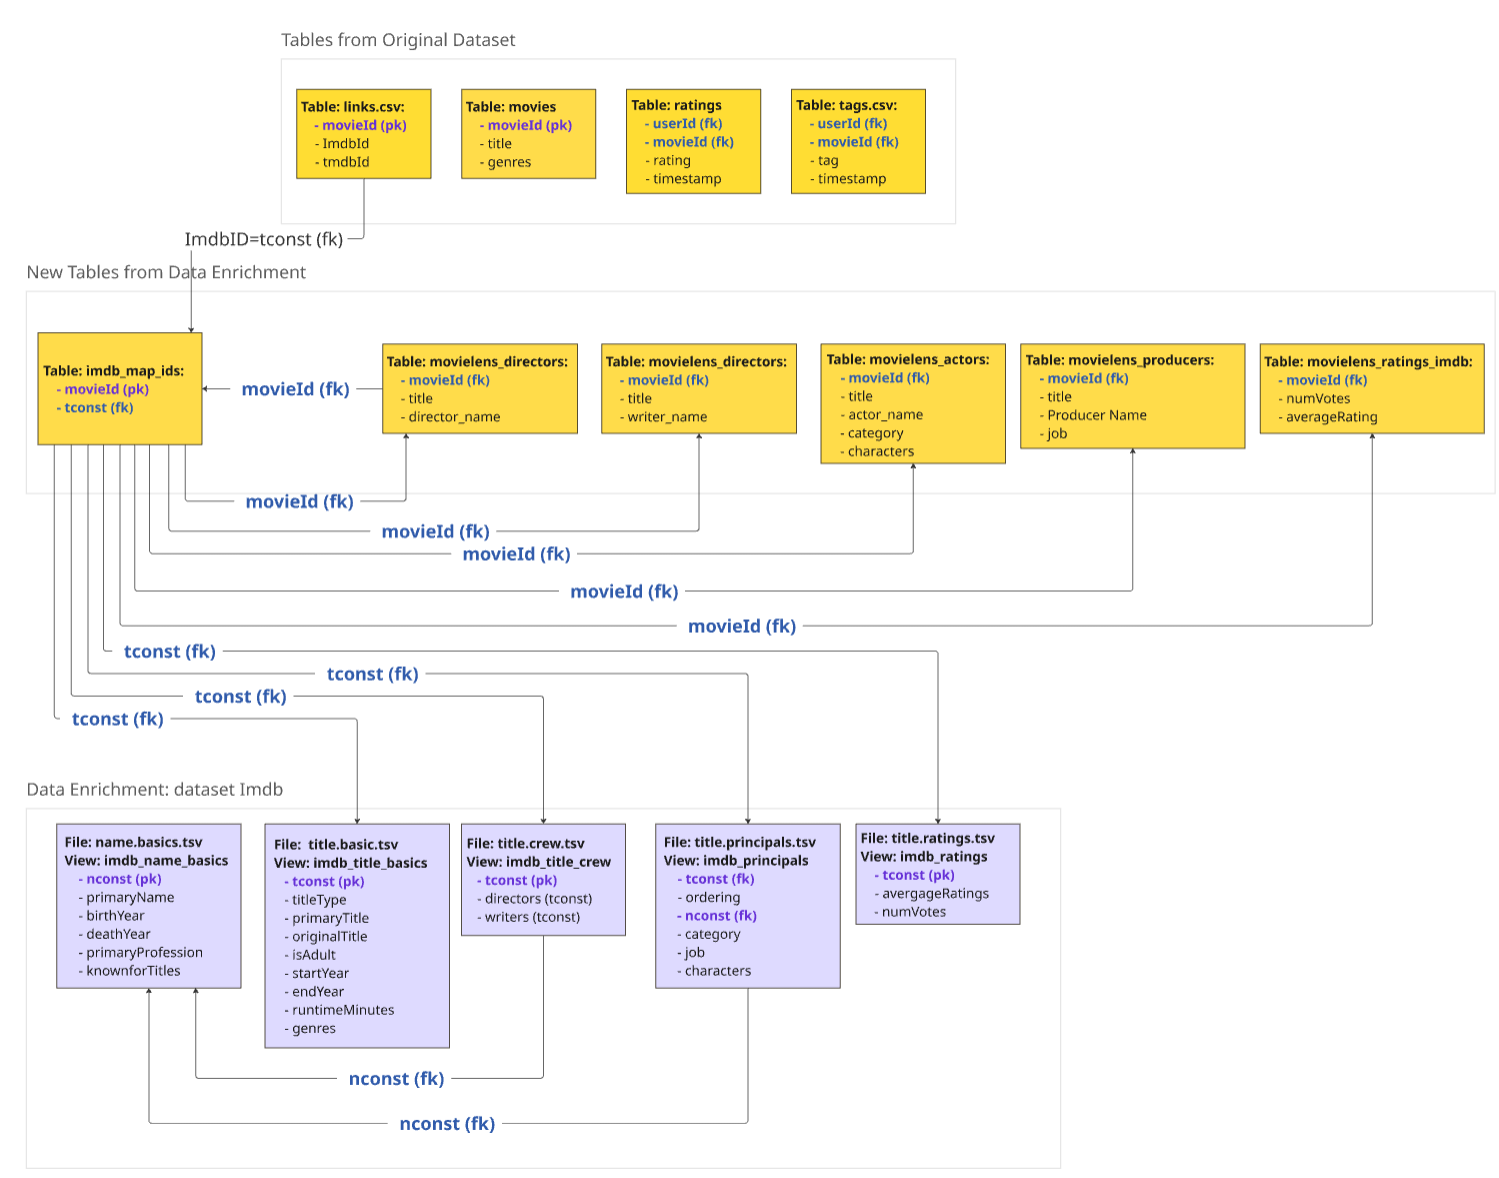

In [63]:
# List of all tables in the database
con.sql("""
SELECT table_name, table_type
FROM information_schema.tables
""").df()

,table_name,table_type
0,imdb_principals_writers,BASE TABLE
1,links,BASE TABLE
2,movielens_actors,BASE TABLE
3,movielens_directors,BASE TABLE
4,movielens_main_producers,BASE TABLE
5,movielens_ratings_imdb,BASE TABLE
6,movielens_writers,BASE TABLE
7,movies,BASE TABLE
8,ratings,BASE TABLE
9,tags,BASE TABLE


#### Fechar a ligação

In [64]:
con.close()
print("Ligação fechada.")

Ligação fechada.
